# Topic modeling example

This exercise introduces topic modeling using the LDA (Latent Dirichlet Allocation) algorithm and the Non-negative Matrix Factorisation (NMF) algorithm.

Topic modeling is an unsupervised approach that allows you to explore large text collections.

Written by: Sumithra Velupillai, with input from Sonia Priou, February 2019 

In [1]:
#! pip install numpy
#!pip install gensim
#!pip uninstall numpy

In [2]:
#!pip install numpy==1.19.3

In [3]:
#!pip install --upgrade numpy
# !pip install --upgrade gensim
# !pip install spacy==3.2.0
# !pip install gensim==3.9.5

In [1]:
# !pip install numpy==1.22.0

In [1]:
## First we need to import all the necessary packages

import string
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import itertools
import zipfile

try:
    import pyLDAvis
except ImportError as e:
    !pip install pyldavis
    import pyLDAvis

import pyLDAvis.gensim as gensimvis
import os
import pandas as pd

import re
import codecs
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import numpy as np
from sklearn.decomposition import NMF, LatentDirichletAllocation
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings; warnings.simplefilter('ignore')

from datetime import datetime
print(datetime.now())

[nltk_data] Downloading package punkt to /Users/lilifang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilifang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


2023-03-10 20:18:11.825012


# 1: Functions for LDA and NMF

In [109]:
def get_tfidf_model(dataframe, text_column, min_df = 0.1, max_df=0.9):
    stopwords = nltk.corpus.stopwords.words('english')
    #new_stopwords = ["um", "ok", "oh", "okay", "yes","get","mhm","yeah","ah","uh","no","hm","wow"] "ok"
    new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get",'yep',"yeah","no","hm","wow",'.','?','-','--',':','mm','oop']
    stopwords.extend(new_stopwords)
    min_df = 90 # ()
    max_df = 8976
    bow_transformer = CountVectorizer(stop_words=stopwords, 
                                  min_df=min_df, 
                                  max_df=max_df).fit(dataframe[text_column])
    document_bow = bow_transformer.transform(dataframe[text_column])
    feature_names = bow_transformer.get_feature_names()
    tfidf_transformer = TfidfTransformer().fit(document_bow)
    document_tfidf= tfidf_transformer.transform(document_bow)
    return feature_names, document_tfidf

In [110]:
def getNMFModel(no_topics, document_tfidf):
    nmf = NMF(n_components=no_topics, 
          random_state=1, 
          l1_ratio=.5, 
          init='nndsvd').fit(document_tfidf)

    W = nmf.transform(document_tfidf)
    H = nmf.components_
    return nmf, W, H

def getLDAModel(no_topics, document_tfidf):
    lda = LatentDirichletAllocation(n_components=no_topics).fit(document_tfidf)
    return lda

In [111]:
# We need a couple of functions to visualise the data
# Preparation for visualisation 
# Written by Sonia Priou, adaptations by Sumithra Velupillai

def display_topics(model, feature_names, no_top_words):
    topic_id_text_lis = [] 
    for topic_idx, topic in enumerate(model.components_):
        topic_id =topic_idx
        topic_keyword =" - ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(topic_id,topic_keyword)
        new_id_keywords = str(topic_id)+':'+topic_keyword
        topic_id_text_lis.append(new_id_keywords)
    return topic_id_text_lis

In [112]:

def get_topic_list(model, feature_names, no_top_words):
    tlist = {}
    for topic_idx, topic in enumerate(model.components_):
        tlist[topic_idx]= str("%d: " % (topic_idx)+", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return tlist

    
def display_topic_representation (model,dataframe,tlist):
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    num_topics = doc_topic.shape[1]
    dico = {'index': doc}
    for n in range(num_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        if len(set(doc_topic[i])) == 1:
            Topic_max.append(num_topics+1)
        else:
            Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    #print(Topic_max)
    tlist[num_topics+1] = 'NONE'
    dico["Topic and its most representative words"] = [tlist[x] for x in Topic_max]
    df_topic = pd.DataFrame(dico)

    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    df_result = df_result.sort_values('Topic most represented')
    
    #Finding within the cluster found by LDA the original file
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.set_style('whitegrid')
    sns.countplot(y='Topic and its most representative words', data = df_result)
    return df_result



In [113]:
def display_file_representation (model,dataframe):
    #Within a file, what is the slipt between topics found
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    no_topics = doc_topic.shape[1]
    topic = np.arange(no_topics)
    dico = {'index': doc}
    for n in range(no_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    df_topic = pd.DataFrame(dico)
    #print(df_topic)
    
    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    
    dico2 = {'Topic': topic}
    for i in df_result['label'].value_counts().index:
        ser = df_result.loc[df_result['label']==i].mean()
        score = ser[2:no_topics+2]
        dico2[i]=score

    df_score = pd.DataFrame(dico2)
    print('For each given file, we calculate the mean percentage of the documents depence to each topic')
    print('')
    print(df_score)
    print(df_result['label'].value_counts().index)

    fig, axs = plt.subplots(ncols=len(dataframe['label'].value_counts()))
    count = 0
    for i in df_result['label'].value_counts().index:
        sns.barplot(x='Topic', y =i ,data = df_score, ax=axs[count])
        count = count + 1
        
    plt.tight_layout()

In [114]:
def calculate_coherence( w2v_model, term_rankings , print_pairs=False):
        overall_coherence = 0.0
        for topic_index in range(len(term_rankings)):
            # check each pair of terms
            pair_scores = []
            for pair in combinations( term_rankings[topic_index], 2 ):
                ## check if word in vocabulary first!! Added by Sumithra
                if pair[0] in w2v_model.wv.index_to_key and pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
                    if print_pairs:
                        print(pair[0], pair[1], w2v_model.wv.similarity(pair[0], pair[1]))
                else:
                    if print_pairs:
                        print('word pair not in vocabulary', pair[0], pair[1])
                    pair_scores.append( 0.0 )
            # get the mean for all pairs in this topic
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
        # get the mean score across all topics
        return overall_coherence / len(term_rankings)

In [115]:
 class TokenGenerator:
        def __init__( self, documents, stopwords ):
            self.documents = documents
            self.stopwords = stopwords
            self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

        def __iter__( self ):
            #print("Building Word2Vec model ...")
            for doc in self.documents:
                tokens = []
                for tok in self.tokenizer.findall( doc ):
                    if tok.lower() in self.stopwords:
                        tokens.append( "<stopword>" )
                    elif len(tok) >= 2:
                        tokens.append( tok.lower() )
                yield tokens


In [116]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

## Read data

In [117]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# read the data that we prepared for analysis
df = pd.read_csv('all_respones_for_all_interviewees_respones_LIWC_words_V2.csv')
print(df.shape)
print(df.columns)



(17953, 8)
Index(['ids', 'diagnosis', 'section', 'pilot_number', 'inter_time', 'response',
       'Nresponse', 'LIWC_response'],
      dtype='object')


In [118]:
print(17953/2)
print(17953*0.005)

8976.5
89.765


In [119]:
import spacy

nlp = spacy.load("en_core_web_sm")

def lemmatize(text):
    doc = nlp(text)
    lemma_list = [token.lemma_ for token in doc]
    return ' '.join(lemma_list)


In [120]:
print(lemmatize('here especailly got ripped annoyed quietly running got'))
# not as good as we expected

here especailly get rip annoyed quietly run get


In [121]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default POS tag
    

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lilifang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lilifang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [122]:
import re
from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
import numpy as np
import pandas as pd


def clean_text2(sentence): 
    lemmatizer = WordNetLemmatizer()
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower()
    sentence = pattern.sub(' ', sentence).strip()
    sentence = ' '.join([lemmatizer.lemmatize(word, pos='v') for word in sentence.split()])

    # Tokenize
    word_list = word_tokenize(sentence)
    
    # stop words
    stopwords_list = stopwords.words('english')
    
    new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get",'yep',"yeah","no","hm","wow",'.','?','-','--',':','mm','oop']
    #new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get","yeah","no","hm","wow",'.','?','-','--',':','mm']
    stopwords_list.extend(new_stopwords)
    
    # puctuation
    punct = set(string.punctuation)
    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    # remove very small words, length < 3
    # they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]
    # remove punctuation
    word_list = [word for word in word_list if word not in punct] 
    
    # Define the corpus of documents as a list of strings
    lemmatizer = WordNetLemmatizer()
    
    pos_tags = pos_tag(word_list)

    lemmas = []
    for word, tag in pos_tags:
        wordnet_tag = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(word, pos=wordnet_tag)
        lemmas.append(lemma)

    lemmatized_sentence = " ".join(lemmas)
    #print(lemmatized_sentence) 
    return lemmatized_sentence


In [123]:
corpus = df['response'].to_list()
# Initialize the CountVectorizer with the desired parameters
vectorizer = CountVectorizer(min_df=10, max_df=8976)

# Fit the vectorizer on the corpus to create a vocabulary
vectorizer.fit_transform(corpus)

# Get the vocabulary of the vectorizer
vocabulary = vectorizer.get_feature_names()


def clean_text(sentence):
    lemmatizer = WordNetLemmatizer()
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower()
    sentence = pattern.sub(' ', sentence).strip()
    sentence = ' '.join([lemmatizer.lemmatize(word, pos='v') for word in sentence.split()])

    # Tokenize
    word_list = word_tokenize(sentence)
    
    # stop words
    stopwords_list = stopwords.words('english')
    
    new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get",'yep',"yeah","no","hm","wow",'.','?','-','--',':','mm','oop']
    #new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get","yeah","no","hm","wow",'.','?','-','--',':','mm']
    stopwords_list.extend(new_stopwords)
    
    # puctuation
    punct = set(string.punctuation)
    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    # remove very small words, length < 3
    # they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]
    # remove punctuation
    word_list = [word for word in word_list if word not in punct] 
    word_list = [word for word in word_list if word in vocabulary]
    # Define the corpus of documents as a list of strings
    lemmatizer = WordNetLemmatizer()
    
    pos_tags = pos_tag(word_list)

    lemmas = []
    for word, tag in pos_tags:
        wordnet_tag = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(word, pos=wordnet_tag)
        lemmas.append(lemma)

    lemmatized_sentence = " ".join(lemmas)
    return lemmatized_sentence

In [124]:
example_sentence =clean_text2("Well like if ripped annoyed I've got gotten a piece of paper and there's like a lot of writing. And I just can't like my brain just I don't know. I can't read it all. I just can't read it because it's too much for me to take in")

In [125]:
print(example_sentence)

well like rip annoy piece paper like lot write like brain know read read much take


In [126]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [127]:
df['sep_response']=df['response'].str.lower().apply(lambda x: word_tokenize(x))
# porter_stemmer = PorterStemmer()
df['response_lemar'] = df['response'].apply(lambda x: clean_text2(str(x)))
# df['response_stem'] = df['response_stem'].apply(lambda x: ' '.join(x))

In [128]:
# # display(df['response_stem'].head())
df['new_response'] = df['response'].apply(lambda x: clean_text(str(x)))

In [129]:
df['words_count'] = df['response_lemar'].str.split().str.len()

In [130]:
ndf = df[df['words_count'] >1]
print(ndf.shape)

(12769, 12)


In [131]:
display(ndf.head())

,ids,diagnosis,section,pilot_number,inter_time,response,Nresponse,LIWC_response,sep_response,response_lemar,new_response,words_count
3,3,ASD.ADHD,Activity Three,974_16_06_2022,[00:01:08],Just says like,True,says,"[just, says, like]",say like,say like,2
4,4,ASD.ADHD,Activity Three,974_16_06_2022,[00:01:18],Okay. There's something you said. Something,True,something you,"[okay, ., there, 's, something, you, said, ., ...",something say something,something say something,3
9,9,ASD.ADHD,Icebreaker,974_16_06_2022,[00:04:16],With the picture cause I had to rush cause I ...,True,picture didn't thought but couldn't wanted,"[with, the, picture, cause, i, had, to, rush, ...",picture cause rush cause forget like like thin...,picture cause rush cause forget like like thin...,12
11,11,ASD.ADHD,Icebreaker,974_16_06_2022,[00:04:47],I do dance on Saturday I do singing at home e...,True,dance singing every since every,"[i, do, dance, on, saturday, i, do, singing, a...",dance saturday sing home every day draw since ...,home every day draw since read every day well,12
12,12,ASD.ADHD,Icebreaker,974_16_06_2022,[00:05:05],So I'm reading this book by an author called R...,True,called called teen,"[so, i, 'm, reading, this, book, by, an, autho...",read book author call rachel renee russell cal...,read book call call favourite book like book,21


## NMF model and the corresponding results

In [132]:
#!pip install --upgrade gensim

In [133]:
# df =df.dropna(subset='LIWC_response')
ndf['index'] = range(0,len (ndf))
# Compute coherence score 
import gensim
kmin, kmax = 8, 35
feature_names, document_tfidf = get_tfidf_model(ndf, 'response_lemar')
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    #print("Applying NMF for k=%d ..." % k )
    # run NMF
    #model = decomposition.NMF( init="nndsvd", n_components=k ) 
    model = decomposition.NMF(n_components=k, 
          random_state=1, 
          l1_ratio=.5, init='nndsvd') # , init='nndsvd'
    W = model.fit_transform(document_tfidf )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )
    
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get",'yep',"yeah","no","hm","wow",'.','?','-','--',':','mm','oop']
# new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get","yeah","no","hm","wow",'.','?','-','--',':','mm']
# new_stopwords =  ["um", "ok", "oh", "okay", "mhm","ah","uh","hm","wow",'.','?','-','--',':','mm']
stopwords.extend(new_stopwords)
docgen = TokenGenerator(df['response_lemar'], stopwords)
# docgen = TokenGenerator(df['response'])
print(docgen)

w2v_model = gensim.models.Word2Vec(docgen, min_count=20, sg=1)
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(feature_names, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append(calculate_coherence( w2v_model, term_rankings ) ) # 
    #print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) ) 
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
print(best_k)

8


In [134]:
# import gensim
# print(gensim.__version__)
# #pycaret 2.3.10 requires gensim<4.0.0, but you have gensim 4.0.0 which is incompatible.


In [135]:
#!pip install gensim==4.0.0

0 like - kind - stuff - something - school - mean - people - would - thing - talk - look - person - want - sort - anything - head - draw - friend - minute - felt
1 really - anything - much - sure - angry - nothing - mind - annoy - excite - emotion - kind - friend - happy - find - keep - want - never - nice - cause - express
2 feel - make - bite - happy - good - quite - angry - calm - upset - emotion - stress - sad - anything - way - start - kind - bad - nice - want - actually
3 think - anything - actually - sure - might - day - situation - need - good - thing - worry - stuff - understand - would - remember - moment - happen - head - fine - bad
4 well - something - sometimes - try - thing - bite - time - talk - quite - lot - help - calm - people - annoy - want - happen - tell - probably - guess - usually
5 know - actually - kind - mean - people - want - guess - explain - work - deal - change - way - already - happen - stuff - reason - understand - next - conversation - always
6 one - fi

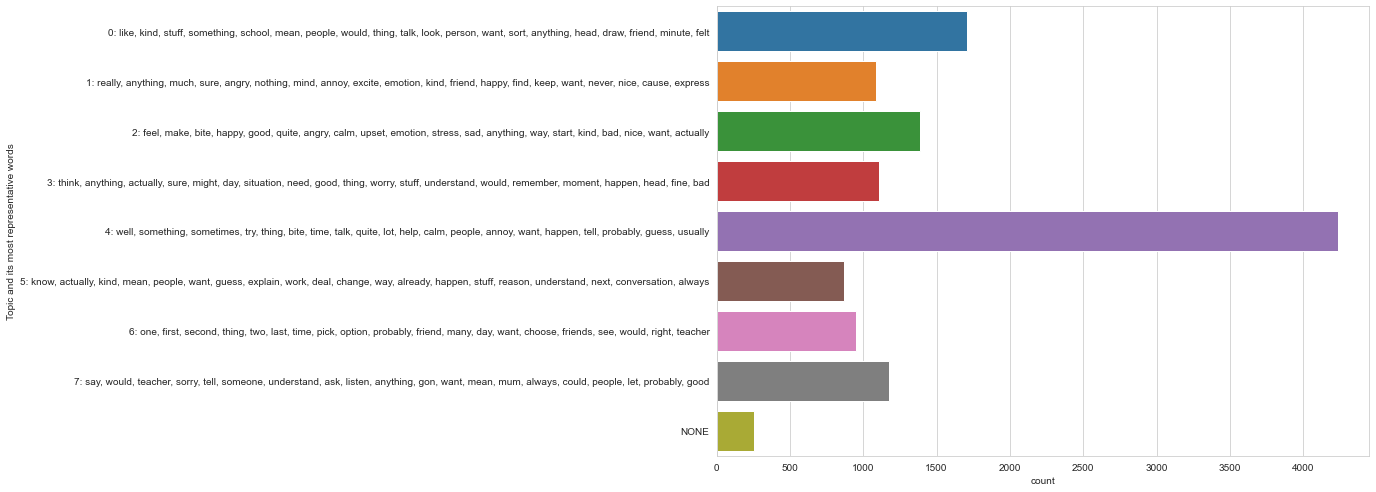

In [136]:
## let's see if the models produce something coherent with the best_k number
no_topics = best_k
#no_topics = 12
## Each topic is represented with a list of words, ranked according to how discriminative they are for that topic. 
## We can use the top ranked words to try to understand what the topic represents.
no_top_words = 20
#lda = getLDAModel(no_topics, document_tfidf)
nmf, W, H = getNMFModel(no_topics, document_tfidf)
result1= display_topics(nmf, feature_names, no_top_words) 
#new_file.write(str(best_k)+','+str(result1)+'\n')
print('Representation of the main topic for each document')
tlist = get_topic_list(nmf,feature_names, no_top_words)
df_result = display_topic_representation(W,ndf,tlist)

In [137]:
df_result.head()

,ids,diagnosis,section,pilot_number,inter_time,response,Nresponse,LIWC_response,sep_response,response_lemar,...,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,Topic most represented,Topic and its most representative words
1751,2337,ASD.ADHD,Icebreaker,986_25_06_2022,[00:03:37],Like fighting games in general.,False,NaN,"[like, fighting, games, in, general, .]",like fight game general,...,0.061876,0.000000,0.000418,0.000000,0.000000,0.000000,0.002542,0.000000,0,"0: like, kind, stuff, something, school, mean,..."
11697,16482,ASD,Activity Three,Pilot52_08_03_2022,[00:22:16],Like I'll try -- I'm going to be trying to get...,True,try trying can't,"[like, i, 'll, try, --, i, 'm, going, to, be, ...",like try try sleep realise sleep like hour,...,0.039842,0.000000,0.000000,0.002391,0.023292,0.000000,0.000000,0.000000,0,"0: like, kind, stuff, something, school, mean,..."
4286,5820,ADHD,Activity Three,967_22_06_2022,[00:53:34],So it's kind of like the ink block test like ...,True,kind people show you,"[so, it, 's, kind, of, like, the, ink, block, ...",kind like ink block test like people show image,...,0.069109,0.001684,0.001667,0.000821,0.012903,0.007180,0.000761,0.001505,0,"0: like, kind, stuff, something, school, mean,..."
2660,3558,ASD.ADHD,Icebreaker,145_12_05_2022,[00:05:11],Make a change during what I like doing?,True,change,"[make, a, change, during, what, i, like, doing...",make change like,...,0.052101,0.000000,0.042039,0.000000,0.003503,0.002543,0.001326,0.001612,0,"0: like, kind, stuff, something, school, mean,..."
2663,3561,ASD.ADHD,Icebreaker,145_12_05_2022,[00:06:30],The things I don't like at home?,True,NaN,"[the, things, i, do, n't, like, at, home, ?]",thing like home,...,0.054561,0.000104,0.000000,0.000946,0.024936,0.000000,0.008298,0.001638,0,"0: like, kind, stuff, something, school, mean,..."


In [138]:
df_result.tail()

,ids,diagnosis,section,pilot_number,inter_time,response,Nresponse,LIWC_response,sep_response,response_lemar,...,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,Topic most represented,Topic and its most representative words
7824,10764,ADHD,Activity Three,050_31_03_2022,[00:51:44],It just naturally just fades gone.,True,NaN,"[it, just, naturally, just, fades, gone, .]",naturally fade,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,NONE
6951,9546,ADHD,Activity One,972_28_06_2022,[00:00:46],Maths and science.,False,NaN,"[maths, and, science, .]",math science,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,NONE
391,518,ASD.ADHD,Activity Four,965_28_06_2022,[01:18:47],Are you referring to a specific type of excite...,True,you specific excitement or,"[are, you, referring, to, a, specific, type, o...",refer specific type excitement,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,NONE
6347,8601,ADHD,Activity Two,470_24_06_2022,[001804],Hes younger,False,NaN,"[hes, younger]",he young,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,NONE
7333,10072,ADHD,Activity Four,Pilot26_26_03_2022,[00:54:05],Until the event or whatever it is over.,True,or,"[until, the, event, or, whatever, it, is, over...",event whatever,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,NONE


In [139]:
print(df_result.columns)

Index(['ids', 'diagnosis', 'section', 'pilot_number', 'inter_time', 'response',
       'Nresponse', 'LIWC_response', 'sep_response', 'response_lemar',
       'new_response', 'words_count', 'index', 'topic0', 'topic1', 'topic2',
       'topic3', 'topic4', 'topic5', 'topic6', 'topic7',
       'Topic most represented', 'Topic and its most representative words'],
      dtype='object')


In [140]:
print(df_result.shape) # 17953

(12769, 23)


In [141]:
new_result = df_result[df_result['Topic and its most representative words'] !='NONE']
print(new_result.shape)

(12516, 23)


In [142]:
new_result = new_result[new_result['new_response'] !='NONE']
print(new_result.shape)

(12516, 23)


In [143]:
newdf2 = new_result[['ids', 'diagnosis','section', 'pilot_number', 'inter_time', 'response', 'response_lemar','new_response','Topic most represented', 'Topic and its most representative words']]

In [144]:
newdf2=newdf2.dropna(subset='new_response')
print(newdf2.shape)

(12516, 10)


In [145]:
newdf2.to_excel('All interviewees responses and the corresponding representative words_withoutNONE_updatedV17.xlsx',index=False)

In [146]:
newdf2.to_csv('All interviewees responses and the corresponding representative words_withoutNONE_updatedV17.csv',index=False)

In [147]:
display(newdf2.tail())

,ids,diagnosis,section,pilot_number,inter_time,response,response_lemar,new_response,Topic most represented,Topic and its most representative words
2326,3187,ASD.ADHD,Icebreaker,144_11_05_2022,[00:03:29],Well at the beginning it says that how I do ...,well begin say feel happiness,well say feel happiness,7,"7: say, would, teacher, sorry, tell, someone, ..."
10795,15136,ASD,Activity Three,913_07_07_2022,[00:39:04],Yeah I'm gonna have to say negotiating with t...,gon say negotiate teacher,say teacher,7,"7: say, would, teacher, sorry, tell, someone, ..."
10562,14800,ASD,Activity Three,161_08_04_2022,[00:19:37],Sorry. It's just come up on the subtitles whe...,sorry come subtitle say room murder kim,sorry come say room,7,"7: say, would, teacher, sorry, tell, someone, ..."
11551,16272,ASD,Activity Three,176_18_04_2022,[00:32:18],I tried to in the beginning especially with m...,try begin especially close friend school say m...,try especially close friend school say mood mo...,7,"7: say, would, teacher, sorry, tell, someone, ..."
5948,8072,ADHD,Activity Three,028_13_04_2022,[00:57:51],Yeah I would say it's quite helpful yeah.,would say quite helpful,would say quite helpful,7,"7: say, would, teacher, sorry, tell, someone, ..."
